In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [3]:
"""透视函数"""


def warpImage(image, src_points, dst_points):
    image_size = (image.shape[1], image.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped_image = cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_LINEAR)
    return warped_image, M, Minv

In [4]:
"""
检测车道线
输入:
binary_warped:二值化的图像，可以通过 OpenCV 的阈值化函数等方式得到
     nwindows:窗口数量，用于将图像划分为多个窗口，在每个窗口中检测车道线；
       margin:窗口宽度，表示车道线像素可能存在的范围，即在当前像素位置左右 margin 个像素范围内均有可能存在车道线；
       minpix:满足法线条件的非零像素点数量的阈值。
       
输出:
      out_img:可视化的图像，其中用颜色标识左右车道线像素点，并在图像中显示拟合的二次函数曲线;
     left_fit:左车道线拟合的二次函数系数；
    right_fit:右车道线拟合的二次函数系数；
        ploty:用于拟合的 y 坐标数组，从 0 到图像高度的最大值。
"""


def find_lane_pixels(binary_warped, nwindows, margin, minpix):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0] // 2 :, :], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int32(histogram.shape[0] // 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int32(binary_warped.shape[0] // nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(
            out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2
        )
        cv2.rectangle(
            out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2
        )

        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = (
            (nonzeroy >= win_y_low)
            & (nonzeroy < win_y_high)
            & (nonzerox >= win_xleft_low)
            & (nonzerox < win_xleft_high)
        ).nonzero()[0]
        good_right_inds = (
            (nonzeroy >= win_y_low)
            & (nonzeroy < win_y_high)
            & (nonzerox >= win_xright_low)
            & (nonzerox < win_xright_high)
        ).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int32(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int32(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [5]:
"""
拟合车道线
输入：
binary_warped: 二值化的图像，可以通过 OpenCV 的阈值化函数等方式得到;
     nwindows: 窗口数量，用于分割图像并检测车道线，与 find_lane_pixels 函数中的参数含义相同;
       margin: 窗口宽度，表示车道线像素可能存在的范围，与 find_lane_pixels 函数中的参数含义相同;
       minpix: 满足法线条件的非零像素点数量的阈值，与 find_lane_pixels 函数中的参数含义相同。
输出：
out_img：可视化的图像，其中用颜色标识左右车道线像素点，并在图像中显示拟合的二次函数曲线；
    left_fit：左车道线拟合的二次函数系数；
    right_fit：右车道线拟合的二次函数系数；
    ploty：用于拟合的 y 坐标数组，从 0 到图像高度的最大值。
"""


def fit_polynomial(binary_warped, nwindows=9, margin=100, minpix=50):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(
        binary_warped, nwindows, margin, minpix
    )

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    try:
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print("The function failed to fit a line!")
        left_fitx = 1 * ploty**2 + 1 * ploty
        right_fitx = 1 * ploty**2 + 1 * ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 255, 0]
    out_img[righty, rightx] = [0, 255, 255]

    return out_img, left_fit, right_fit, ploty

In [6]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]

    return left_fitx, right_fitx, ploty, left_fit, right_fit

In [7]:
def search_around_poly(binary_warped, left_fit, right_fit):
    margin = 60

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = (
        nonzerox > (left_fit[0] * (nonzeroy**2) + left_fit[1] * nonzeroy + left_fit[2] - margin)
    ) & (nonzerox < (left_fit[0] * (nonzeroy**2) + left_fit[1] * nonzeroy + left_fit[2] + margin))
    right_lane_inds = (
        nonzerox
        > (right_fit[0] * (nonzeroy**2) + right_fit[1] * nonzeroy + right_fit[2] - margin)
    ) & (
        nonzerox
        < (right_fit[0] * (nonzeroy**2) + right_fit[1] * nonzeroy + right_fit[2] + margin)
    )

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    # 调用函数fit_poly
    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_poly(
        binary_warped.shape, leftx, lefty, rightx, righty
    )

    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
    right_line_window2 = np.array(
        [np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))]
    )
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int32([left_line_pts]), (0, 255, 255))
    cv2.fillPoly(window_img, np.int32([right_line_pts]), (255, 255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    return result, left_fit, right_fit, ploty

In [8]:
"""
    undist: 标定后的图像
bin_warped: 提取车道线后的图像
color_warp: 透视后的图像
 left_fitx: 左车道线拟合曲线上的所有x值；
right_fitx: 右车道线拟合曲线上的所有x值。
"""


def drawing(undist, bin_warped, color_warp, left_fitx, right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(bin_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int32([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

In [9]:
def print_img(img, title):
    if img.ndim == 3:  # cv库的图片是bgr，输出要先转回rgb
        img = img[:, :, ::-1]
    plt.title(title)
    plt.imshow(img, plt.cm.gray)  # rgb会忽略颜色指定
    plt.show()


def read_img(path):
    img = plt.imread(path)  # plt读图，rgb格式，可读中文路径，用cv2的可以改系统utf8(beta)编码
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img

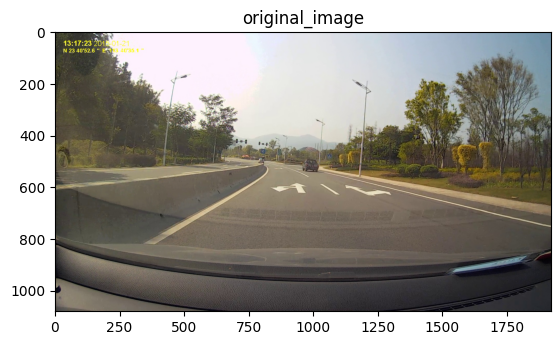

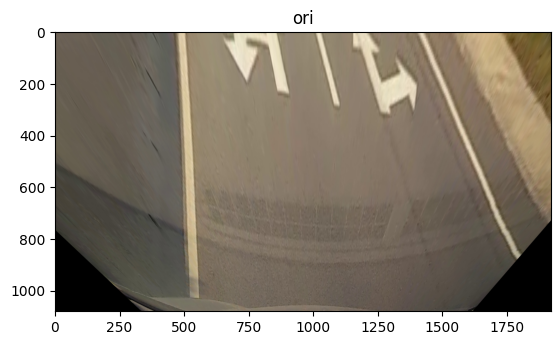

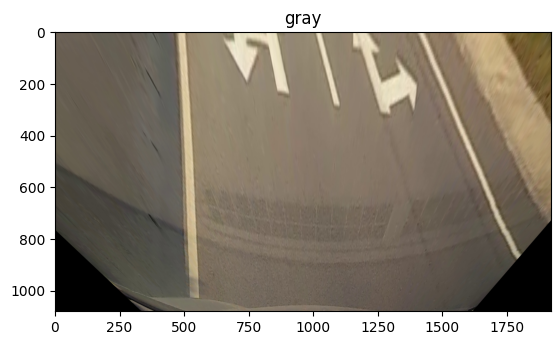

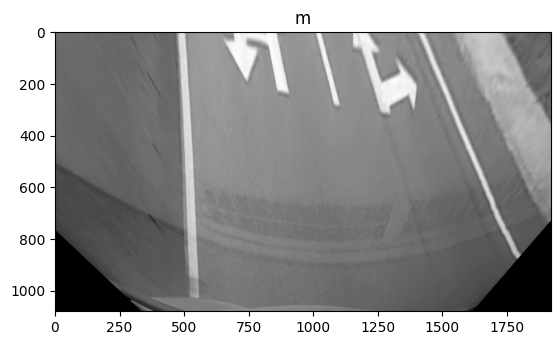

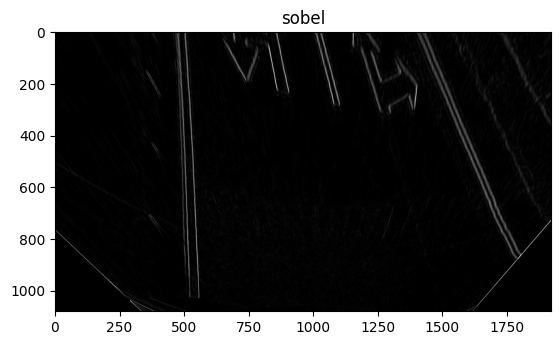

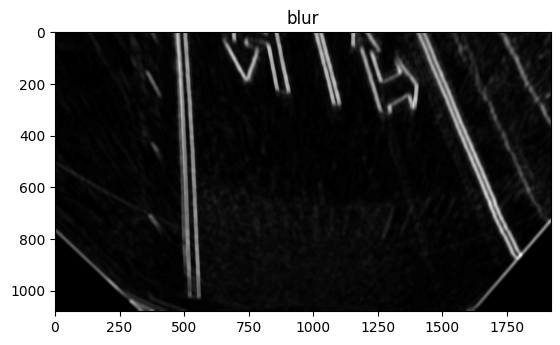

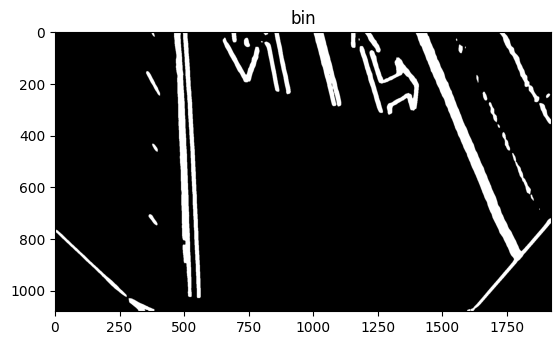

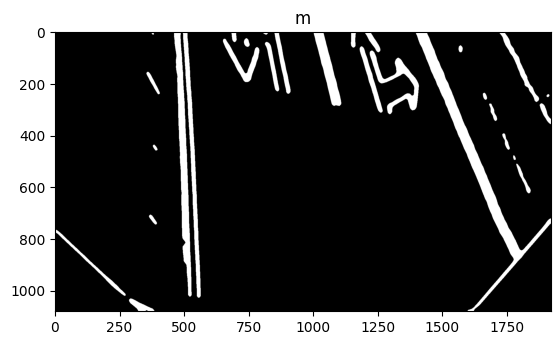

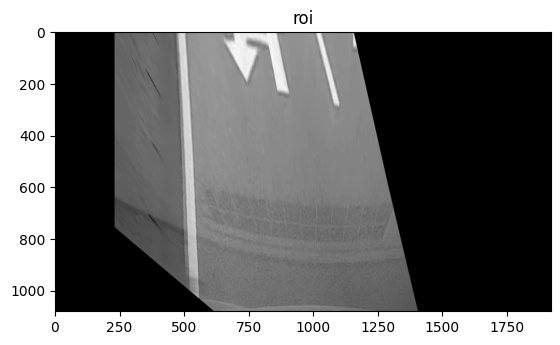

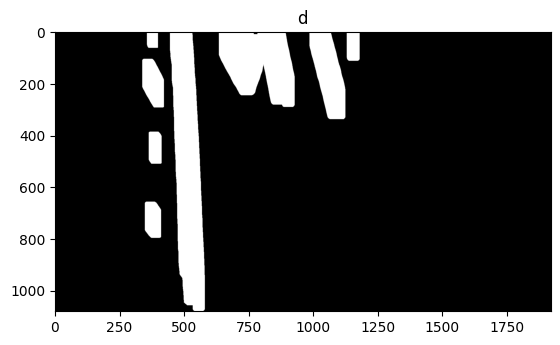

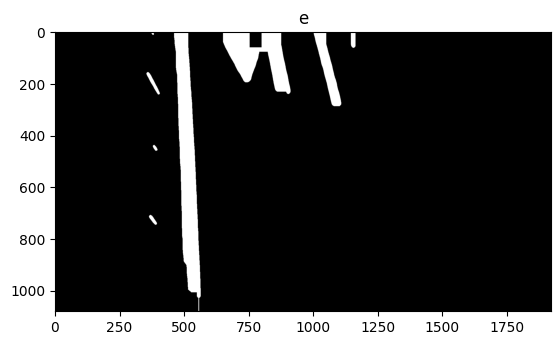

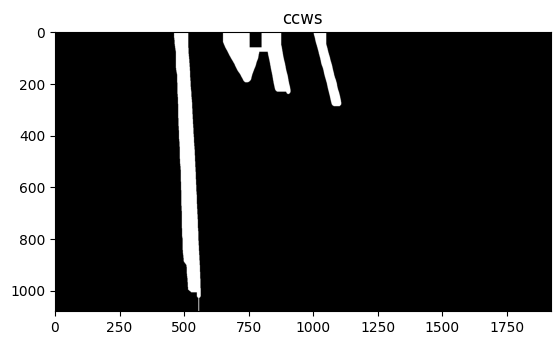

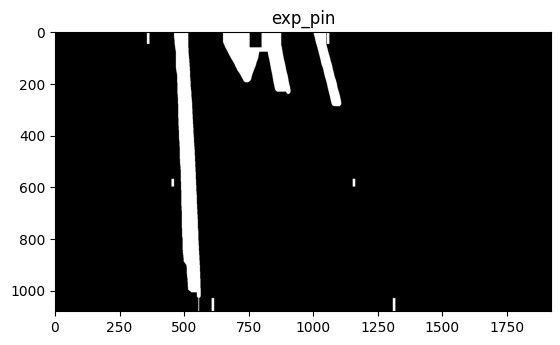

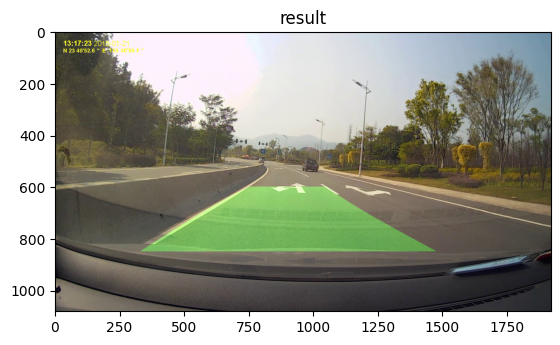

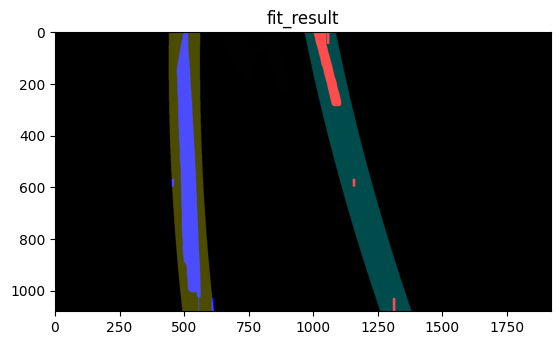

In [11]:
def pre_process(img_origin, show_every_step=False):
    """滤波"""
    img = img_origin.copy()
    if show_every_step:
        print_img(img, "ori")

    #转灰度
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if show_every_step:
        print_img(img, "gray")

    #中值滤波去噪
    img = cv2.medianBlur(gray, 9)
    if show_every_step:
        print_img(img, "m")

    #Sobel算子提取垂直线和斜线
    img = cv2.Sobel(img, cv2.CV_16S, 1, 0)
    img = cv2.convertScaleAbs(img)
    if show_every_step:
        print_img(img, "sobel")

    #均值滤波，借由均值滤波的模糊效果，尝试在经过Sobel后可能不连续的线段之间添加亮点，方便后续二值化时将车道线连起来
    img = cv2.blur(img, (15, 15))
    if show_every_step:
        print_img(img, "blur")

    # 二值化，将均值滤波后模糊的车道边缘变得锐利以及配合均值滤波让不连续的车道变得连续
    th, img = cv2.threshold(img, 15, 255, cv2.THRESH_BINARY)
    if show_every_step:
        print_img(img, "bin")

    # 中值滤波，去除部分二值化带来的小亮点以及进一步锐化图像
    img = cv2.medianBlur(img, 15)
    if show_every_step:
        print_img(img, "m")

    """定义感兴趣区域，并剪裁掉边缘不需要的部分"""
    mask = np.zeros_like(img)
    ignore_mask_color = 255
    left_bottom = [img.shape[1] * 0.32, img.shape[0]]  # 0.22
    left_low = [img.shape[1] * 0.12, img.shape[0] * 0.70]  # 0.22
    apex_1 = [img.shape[1] * 0.12, 0]  # 0.22
    apex_2 = [img.shape[1] * 0.6, 0]
    right_low = [img.shape[1] * 0.67, img.shape[0] * 0.55]
    right_bottom = [img.shape[1] * 0.73, img.shape[0]]
    vertices = np.array([left_bottom, left_low, apex_1, apex_2, right_low, right_bottom], np.int32)
    # [vertices]中的点组成了多边形，将在多边形内的掩膜像素点保留，
    cv2.fillPoly(mask, [vertices], ignore_mask_color)
    # 和掩膜做"与"操作，即仅留下多边形部分的图像
    img = cv2.bitwise_and(img, mask)
    if show_every_step:
        roi_area = cv2.bitwise_and(gray, mask)
        print_img(roi_area, "roi")

    # 膨胀，再次让不连续的车道连接起来，但会让车道线变宽
    img = cv2.dilate(img, cv2.getStructuringElement(cv2.MORPH_RECT, (33, 102)))
    if show_every_step:
        print_img(img, "d")

    # 腐蚀，让车道宽度变回正常（均值滤波和膨胀令车道变宽），同时去除部分较大的亮点
    img = cv2.erode(img, cv2.getStructuringElement(cv2.MORPH_RECT, (33, 102)))
    if show_every_step:
        print_img(img, "e")

    #由于视频中的道路情况大多数情况下比较糟糕，经过上述处理后会有比较多的亮点
    #利用连通区域面积，设置一个阈值将其过滤掉
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        img, connectivity=8, ltype=None
    )
    # print(stats)
    for area in range(1, len(stats)):
        if stats[area][4] < 2000:
            for i in range(stats[area][1], stats[area][1] + stats[area][3]):
                for j in range(stats[area][0], stats[area][0] + stats[area][2]):
                    img[i, j] = 0
    if show_every_step:
        print_img(img, "ccws")

    #由于拟合是利用图片切分为多个窗口后的亮度分布进行拟合，
    #所以车道标志，恶劣的车道情况都会对拟合造成巨大影响
    #因此在透视变换后，车道标志的主要位置置零，当中的掩膜多边形是贴着底边的
    #因底边是车道线起始位置，对后续拟合有极大影响，因此为了增加大多情况的稳定性，牺牲变道时的效果
    # 车道标志
    ignore_mask_color = 0
    left_bottom = [750, 1080]  # 0.22
    apex_1 = [650, 400]  # 0.22
    apex_2 = [900, 400]
    right_bottom = [1100, 1080]
    vertices = np.array([left_bottom, apex_1, apex_2, right_bottom], np.int32)
    cv2.fillPoly(img, [vertices], ignore_mask_color)
    
    #由于车道线存在虚线，没有线段的拟合窗口（车道线起始位置缺失）会出现拟合失败、不稳定的情况
    #因此利用先验知识，在透视变换后车道常出现的位置中，在上中下三个位置，设置一小亮点，引导车道线拟合
    #其大小在有车道时不足以影响曲线拟合，而在面对虚线，缺失线段时可以起到引导作用，使车道线变得稳定
    #但这属于经验设置，不能覆盖不同车辆、不同道路的情况，泛用性差
    #右下，右边虚线
    for i in range(1030, 1080):
        for j in range(1305, 1315):
            img[i, j] = 255
    # 左下，左边虚线
    for i in range(1030, 1080):
        for j in range(605, 615):
            img[i, j] = 255
    # 左上，左边虚线
    for i in range(0, 50):
        for j in range(355, 365):
            img[i, j] = 255
    # 右上，右边虚线
    for i in range(0, 50):
        for j in range(1050, 1060):
            img[i, j] = 255
    # 左中，左边虚线
    for i in range(570, 600):
        for j in range(450, 460):
            img[i, j] = 255
    # 右中，右边虚线
    for i in range(570, 600):
        for j in range(1150, 1160):
            img[i, j] = 255
    if show_every_step:
        print_img(img, "exp_pin")

    return img


# 主函数
if __name__ == "__main__":
    # 首先导入图像expsyntax-03107 expline-05054
    img0 = read_img(
        r"C:\Code\JupyterLab\lane_detection\video_frame\05054.jpg"
    )
    print_img(img0, "original_image")
    # 透视前的车道线区域四边形
    src = np.float32([[750, 600], [1150, 600], [1300, 850], [250, 850]])
    # 透视后区域四个点坐标
    dst = np.float32([[500, 0], [1200, 0], [1200, 1080], [500, 1080]])
    # 进行车道线区域透视变换
    img, M, Minv = warpImage(img0, src, dst)

    
    gray = pre_process(img,True)
    # gray = pre_process(img)

    # 利用不知道什么东西反正就是可以输出车道线的位置
    out_img, left_fit0, right_fit0, ploty = fit_polynomial(gray, nwindows=7, margin=200, minpix=30)
    output, left_fit, right_fit, ploty = search_around_poly(gray, left_fit0, right_fit0)
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    result = drawing(img0, gray, img, left_fitx, right_fitx)
    print_img(result, "result")
    print_img(output, "fit_result")

In [379]:
"""对于视频进行处理并且输出结果"""
import cv2
import numpy as np
from tqdm import *

# 读取视频
cap = cv2.VideoCapture(r"C:\Code\Dataset\car_net_hw\2-中山大学-张荣辉-车道线检测素材-20230505.AVI")

# 视频帧率和尺寸
fps = 30
width = 1920
height = 1080

# 定义输出视频的格式
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter("output_cut4.mp4", fourcc, fps, (width, height))

# 定义源点和目标点，用于变换
# 透视前需要处理的区域
src = np.float32([[750, 600], [1150, 600], [1300, 850], [250, 850]])
# 透视后区域四个点坐标
dst = np.float32([[500, 0], [1200, 0], [1200, 1080], [500, 1080]])
total_frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_count = 0
with tqdm(total=total_frame_count) as pbar:
    while True:
        ret, frame = cap.read()
        if ret:
            # 进行透视变换
            img, M, Minv = warpImage(frame, src, dst)
            # 将图像转换为灰度
            gray = pre_process(img)
            # 利用不知道什么东西反正就是可以输出车道线的位置
            out_img, left_fit0, right_fit0, ploty = fit_polynomial(
                gray, nwindows=7, margin=200, minpix=30
            )
            output, left_fit, right_fit, ploty = search_around_poly(gray, left_fit0, right_fit0)
            left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
            right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
            result = drawing(frame, gray, img, left_fitx, right_fitx)

            # 写入输出视频
            out.write(result)
            pbar.update(1)
            frame_count += 1

        else:
            pbar.update(total_frame_count - frame_count)
            pbar.close()
            break

# 释放资源
cap.release()
out.release()
# cv2.destroyAllWindows()

100%|████████████████████████████████████████████████████████████████████████████| 17962/17962 [37:29<00:00,  7.98it/s]

258
